In [1]:
!ls /kaggle/input/pyvips-python-and-deb-package
# intall the deb packages
!dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb
# install the python wrapper
!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index

linux_packages	python_packages
Selecting previously unselected package autoconf.
(Reading database ... 108782 files and directories currently installed.)
Preparing to unpack .../autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package autopoint.
Preparing to unpack .../autopoint_0.19.8.1-10build1_all.deb ...
Unpacking autopoint (0.19.8.1-10build1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package bzip2-doc.
Preparing to unpack .../bzip2-doc_1.0.8-2_all.deb ...
Unpacking bzip2-doc (1.0.8-2) ...
Selecting previously unselected package debhelper.
Preparing to unpack .../debhelper_12.10ubuntu1_all.deb ...
Unpacking debhelper (12.10ubuntu1

In [2]:
import os, glob

os.environ['VIPS_CONCURRENCY'] = '4'
os.environ['VIPS_DISC_THRESHOLD'] = '8gb'

!pip list | grep pyvips

pyvips                                   2.2.2


## Importing Libraries

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pyvips
from scipy.ndimage import gaussian_filter
from skimage.morphology import erosion, dilation

from tqdm import tqdm
import gc
from skimage.measure import label, regionprops, regionprops_table
from collections import Counter


In [4]:
DATASET_FOLDER = "/kaggle/input/mayo-clinic-strip-ai/"

In [5]:
path_csv = os.path.join(DATASET_FOLDER, "train.csv")
df_train = pd.read_csv(path_csv)
display(df_train.head())

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [6]:
# Mapping from format strings to NumPy data types
format_to_dtype = {
    "uchar": np.uint8,
    "char": np.int8,
    "ushort": np.uint16,
    "short": np.int16,
    "uint": np.uint32,
    "int": np.int32,
    "float": np.float32,
    "double": np.float64,
    "complex": np.complex64,
    "dpcomplex": np.complex128,
}

## Data Preprocessing Functions

In [16]:
def read_image_pyvips(path, max_size=2000):
    """
    Read an image using pyvips and convert it to a numpy array.

    Args:
    - path (str): Path to the image file.
    - max_size (int): Maximum size for thumbnail creation.

    Returns:
    - numpy.ndarray: Image as a numpy array.
    """
    image = pyvips.Image.thumbnail(path, max_size)
    image = np.ndarray(
        buffer=image.write_to_memory(),
        dtype=format_to_dtype[image.format],
        shape=[image.height, image.width, image.bands],
    )

    return image


def multi_dilation(image, iteration_num):
    """
    Perform multiple dilation operations on the input image.

    Args:
    - image (numpy.ndarray): Input image.
    - iteration_num (int): Number of dilation iterations.

    Returns:
    - numpy.ndarray: Resulting image after dilation.
    """
    matrix = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    for i in range(iteration_num):
        image = dilation(image, matrix)
    return image


def multi_erosion(image, iteration_num):
    """
    Perform multiple erosion operations on the input image.

    Args:
    - image (numpy.ndarray): Input image.
    - iteration_num (int): Number of erosion iterations.

    Returns:
    - numpy.ndarray: Resulting image after erosion.
    """
    matrix = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    for i in range(iteration_num):
        image = erosion(image, matrix)
    return image


def create_boxes(orig_image_size, region_size, overlap_area=1):
    """
    Create bounding boxes based on the original image size and specified region size.

    Args:
    - orig_image_size (tuple): Size of the original image (height, width).
    - region_size (int): Size of the regions.
    - overlap_area (int): Overlapping area factor.

    Returns:
    - list: List of bounding box boundaries.
    """
    top_x = np.arange(
        orig_image_size[0] % region_size // 2,  # shift to center grid
        orig_image_size[0],
        int(region_size / overlap_area),
    )[:-1]
    top_y = np.arange(
        orig_image_size[1] % region_size // 2,  # shift to center grid
        orig_image_size[1],
        int(region_size / overlap_area),
    )[:-1]
    box_boundries = []
    for x in top_x:
        right_space = orig_image_size[0] - (x + region_size)
        if right_space > 0:
            boundaries_x = (x, x + region_size)
        else:
            boundaries_x = (x + right_space, x + right_space + region_size)

        for y in top_y:
            down_space = orig_image_size[1] - (y + region_size)
            if down_space > 0:
                boundaries_y = (y, y + region_size)
            else:
                boundaries_y = (y + down_space, y + down_space + region_size)
            box_boundries.append((boundaries_x, boundaries_y))

    return box_boundries


def get_img_prop(sub_image, min_saturation=20):
    """
    Calculate the proportion of the image that is not background.

    Args:
    - sub_image (numpy.ndarray): Input sub-image.
    - min_saturation (int): Minimum saturation value for low saturation check.

    Returns:
    - float: Proportion of the image that is not background.
    """
    hsv = cv2.cvtColor(sub_image, cv2.COLOR_RGB2HSV)
    _, s, _ = cv2.split(hsv)

    low_sat = (s < min_saturation).mean()

    counts = np.bincount((sub_image.mean(-1).flatten().astype(int)))
    background_prop = counts[np.argsort(counts)[::-1][:3]].sum() / counts.sum()

    background_prop = max(background_prop, low_sat)

    return 1 - background_prop


def denoise(binary_image, n=10, m=2):
    """
    Denoise the binary image using multiple erosion and dilation operations.

    Args:
    - binary_image (numpy.ndarray): Binary input image.
    - n (int): Number of erosion iterations.
    - m (int): Number of dilation iterations.

    Returns:
    - numpy.ndarray: Denoised binary image.
    """
    binary_image = multi_erosion(binary_image, m)
    binary_image = multi_dilation(binary_image, m)
    binary_image = multi_dilation(binary_image, n)
    binary_image = multi_erosion(binary_image, n)
    binary_image = multi_erosion(binary_image, m)
    return multi_dilation(binary_image, m)


def euclidian_dist(image1, image2):
    """
    Calculate Euclidean distance between two images.

    Args:
    - image1 (numpy.ndarray): First input image.
    - image2 (numpy.ndarray): Second input image.

    Returns:
    - float: Euclidean distance between the images.
    """
    image1 = cv2.resize(image1, (256, 256)).astype(float) / 255
    image2 = cv2.resize(image2, (256, 256)).astype(float) / 255
    image1 = image1.mean(-1)
    image2 = image2.mean(-1)
    image1 = gaussian_filter(image1, sigma=1)
    image2 = gaussian_filter(image2, sigma=1)
    return ((image1 < 0.98) != (image2 < 0.98)).astype(float).mean() ** 2


def shape_dist(image1, image2):
    """
    Calculate shape distance between two images.

    Args:
    - image1 (numpy.ndarray): First input image.
    - image2 (numpy.ndarray): Second input image.

    Returns:
    - float: Shape distance between the images.
    """
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    return abs(h1 - h2) / min(h1, h2) + abs(w1 - w2) / min(w1, w2)


def component_distance(img, labeled, df, min_size=500):
    """
    Calculate distances between components based on Euclidean and shape distances.

    Args:
    - img (numpy.ndarray): Original image.
    - labeled (numpy.ndarray): Labeled image components.
    - df (pandas.DataFrame): DataFrame containing component information.
    - plot (bool): Flag to enable/disable plotting of component crops.
    - min_size (int): Minimum size for valid components.

    Returns:
    - tuple: List of component crops, distance matrix, and indices to ignore.
    """
    crops, to_ignore = [], []
    min_size = min(df["area"].max(), min_size)

    for i in range(len(df)):
        x0, y0, x1, y1 = df[["bbox-0", "bbox-1", "bbox-2", "bbox-3"]].values[i]

        if df["area"].values[i] < min_size:
            to_ignore.append(i)

        crop = img[x0:x1, y0:y1].astype(np.uint8)

        crops.append(crop)

    dists = np.eye(len(df))
    for i in range(len(df)):
        for j in range(i):
            d = euclidian_dist(crops[i], crops[j])
            d2 = shape_dist(crops[i], crops[j])
            dists[i, j] = d + 0.5 * (d2 > 0.4)
            dists[j, i] = d + 0.5 * (d2 > 0.4)

    dists[to_ignore] = 1
    dists[:, to_ignore] = 1

    return crops, dists, to_ignore


def get_duplicates(dists, threshold=0.15):
    """
    Identify duplicate components based on distance matrix.

    Args:
    - dists (numpy.ndarray): Distance matrix between components.
    - threshold (float): Threshold for identifying duplicates.

    Returns:
    - list: List of tuples containing duplicate indices and distances.
    """
    duplicates = []

    for i in range(len(dists)):
        for j in range(i):
            dist = dists[i, j]
            if dist < threshold:
                duplicates.append((i, j, dist))
    duplicates = sorted(duplicates, key=lambda x: x[2])
    return duplicates


def get_clusters(df_comp, duplicates, max_size=3):
    """
    Assign clusters to components based on identified duplicates.

    Args:
    - df_comp (pandas.DataFrame): DataFrame containing component information.
    - duplicates (list): List of tuples containing duplicate indices and distances.
    - max_size (int): Maximum size of a cluster.

    Returns:
    - None
    """
    df_comp['cluster'] = -1

    for i, d in enumerate(duplicates):
        clust_idx = i

        if df_comp['cluster'][d[0]] >= 0 and df_comp['cluster'][d[1]] >= 0:
            continue

        elif df_comp['cluster'][d[0]] >= 0:
            clust_idx = df_comp['cluster'][d[0]]
            if Counter(df_comp['cluster'])[clust_idx] >= max_size:
                continue

        elif df_comp['cluster'][d[1]] >= 0:
            clust_idx = df_comp['cluster'][d[1]]
            if Counter(df_comp['cluster'])[clust_idx] >= max_size:
                continue

        df_comp.loc[d[0], 'cluster'] = clust_idx
        df_comp.loc[d[1], 'cluster'] = clust_idx



def get_normalization_ratio(img, tile_size=512, min_saturation=20):
    """
    Calculate the normalization ratio based on image properties.

    Args:
    - img (numpy.ndarray): Input image.
    - tile_size (int): Size of tiles for processing.
    - min_saturation (int): Minimum saturation value.

    Returns:
    - numpy.ndarray: Normalization ratio.
    """
    h, w, _ = img.shape
    grid = create_boxes((h, w), tile_size)

    for x, y in grid:
        tile = img[x[0]: x[1], y[0]: y[1]]
        img_prop = get_img_prop(tile, min_saturation=min_saturation)

        if img_prop < 0.25:
            ratio = np.mean(tile, (0, 1)) / np.array([255.0, 255.0, 255.0])
            return ratio

    return None


def normalize(image, ratio=None):
    """
    Normalize the image using the provided ratio.

    Args:
    - image (numpy.ndarray): Input image.
    - ratio (numpy.ndarray or None): Normalization ratio.

    Returns:
    - numpy.ndarray: Normalized image.
    """
    if ratio is None:
        return image
    else:
        return np.clip((image / ratio), 0, 255).astype(np.uint8)


def remove_bubble(img):
    """
    Remove bubbles from the input image.

    Args:
    - img (numpy.ndarray): Input image.

    Returns:
    - numpy.ndarray: Image with bubbles removed.
    """
    bubble = (img.mean(-1) < 250) & (img.mean(-1) > 220) & (img.std(-1) < 5)
    bubble = bubble.astype(float)

    bubble = multi_dilation(bubble, 2)
    bubble = multi_erosion(bubble, 5)
    bubble = multi_dilation(bubble, 3)

    bubble = bubble[..., None].astype(int)

    return img * (1 - bubble) + bubble * 255


def remove_background(grayscale, img=None):
    """
    Remove the background from the grayscale image.

    Args:
    - grayscale (numpy.ndarray): Grayscale image.
    - img (numpy.ndarray or None): Original color image (optional).

    Returns:
    - numpy.ndarray: Grayscale image with background removed.
    """
    counts = np.bincount(grayscale.flatten())

    bg_prop = np.max(counts) / grayscale.size
    bg = np.argmax(counts)

    if img is None:
        if bg_prop > 0.2:
            grayscale[grayscale == bg] = 255
        return grayscale
    else:
        if bg_prop > 0.2:
            img[grayscale[..., None] == bg] = 255
        return img

    
def random_crop(crop1, crop2):
    """
    Generate a random crop from one of the input crops.

    Args:
    - crop1 (numpy.ndarray): First crop.
    - crop2 (numpy.ndarray): Second crop.

    Returns:
    - numpy.ndarray: Randomly selected crop.
    """
    shape1 = crop1.shape[:2]
    shape2 = crop2.shape[:2]

    crop = crop1.copy()

    if shape1[0] > shape2[0]:
        x_start = np.random.randint(shape1[0] - shape2[0])
        crop = crop[x_start: x_start + shape2[0]]

    if shape1[1] > shape2[1]:
        y_start = np.random.randint(shape1[1] - shape2[1])
        crop = crop[:, y_start: y_start + shape2[1]]

    return crop


def match_crops(crop1, crop2, threshold=0.05, trials=100, rot=False):
    """
    Match two crops based on distance threshold.

    Args:
    - crop1 (numpy.ndarray): First crop.
    - crop2 (numpy.ndarray): Second crop.
    - threshold (float): Distance threshold for matching.
    - trials (int): Number of trials for attempting matches.
    - rot (bool): Whether to include rotations in matching.
    - plot (bool): Whether to visualize matched crops.

    Returns:
    - bool: True if a match is found, False otherwise.
    """
    for t in range(trials):
        if 0 < t < 4:  # try rotations
            th = threshold
            cropr = np.rot90(crop1.copy(), k=t)
        else:  # crop
            th = threshold * 2/3
            cropr = random_crop(crop1, crop2)

        if rot:
            if np.random.random() < 0.5:
                cropr = np.rot90(cropr, k=np.random.randint(1, 4))

        dist = euclidian_dist(crop2.copy(), cropr.copy())

        if dist < th:
            return True

    return False


def compute_dist_matrix(df):
    """
    Compute the distance matrix between components.

    Args:
    - df (pandas.DataFrame): DataFrame containing component information.

    Returns:
    - numpy.ndarray: Distance matrix between components.
    """
    mat = np.ones((len(df), len(df))) * 100
    for i in range(len(df)):
        for j in range(i):
            dx = np.abs(df["xc"][i] - df["xc"][j]) / (0.5 * df["h"][i] + 0.5 * df["h"][j])
            dy = np.abs(df["yc"][i] - df["yc"][j]) / (0.5 * df["w"][i] + 0.5 * df["w"][j])
            d = np.sqrt(dx ** 2 + dy ** 2)
            mat[i, j] = d
            mat[j, i] = d
    return mat


def get_roi(df_comp, shape, found_crop=False, min_size=500, margin=5):
    """
    Get regions of interest (ROI) based on connected components.

    Args:
    - df_comp (pandas.DataFrame): DataFrame containing component information.
    - shape (tuple): Shape of the original image.
    - found_crop (bool): Whether a matched crop has been found.
    - min_size (int): Minimum size for valid components.
    - margin (int): Margin for extending the region of interest.

    Returns:
    - tuple: Coordinates of the region of interest (x0, x1, y0, y1, df_comp_kept).
    """
    order = ['bbox-0', 'bbox-1'] if shape[0] >= shape[1] else ['bbox-1', 'bbox-0']
    order = ['-area'] + order if found_crop else order

    df_comp = df_comp.sort_values(order).reset_index(drop=True)

    m = margin
    df_comp = df_comp[df_comp['area'] > min_size]

    if df_comp['cluster'].max() >= 0:  # has clusters, keep one per cluster.
        if found_crop or df_comp['cluster'].max() >= 2:  # one per unclustered + increase margin
            df_comp = df_comp[(~df_comp.duplicated(subset="cluster"))]
            m = margin * 5
        else:
            df_comp = df_comp[(df_comp['cluster'] == -1) | (~df_comp.duplicated(subset="cluster"))]

    x0, y0 = df_comp[['bbox-0', 'bbox-1']].min()
    x1, y1 = df_comp[['bbox-2', 'bbox-3']].max()

    x0 = max(0, x0 - m)
    y0 = max(0, y0 - m)
    x1 = min(shape[0], x1 + m)
    y1 = min(shape[1], y1 + m)

    return x0, x1, y0, y1, df_comp


## Preocessing Steps

In [21]:
def process_image(image_path,MIN_SIZE=750,N=6,M=2,MARGIN = 5,THRESHOLD_DUP = 0.1,SIZE = 256
,BIN_THRESH = 240,SIGMA = 2,MIN_PROP = 0.02,IMG_SIZE = 1024 ):
    img_path = image_path
    image = read_image_pyvips(DATASET_FOLDER + img_path, max_size=20000)
    
    # Step 1: Crop and normalize the image
    ratio = get_normalization_ratio(image)
    orig_shape = image.shape[:2]
    image_dimensions  = np.array(image.shape[:2])
    resize_factor = np.min(image_dimensions ) / SIZE
    image_dimensions  = (image_dimensions  / resize_factor).astype(int)

    resized_image  = cv2.resize(image, image_dimensions [::-1])
    resized_image  = normalize(resized_image , ratio)
    
    plt.imshow(resized_image)
    plt.title("Step 1: Crop and Normalize")
    plt.show()

    # Step 2: Remove bubbles and background, apply Gaussian filter
    resized_image  = remove_bubble(resized_image )
    grayscale = resized_image .mean(-1).astype(int)
    grayscale = remove_background(grayscale)
    grayscale = gaussian_filter(grayscale, sigma=SIGMA)
    
    plt.imshow(grayscale, cmap='gray')
    plt.title("Step 2: Remove Bubbles, Background, and Apply Gaussian Filter")
    plt.show()
    
    
    # Step 3: Convert to binary image, denoise, and label connected components
    binary_image = (grayscale < BIN_THRESH).astype(float)
    binary_image = denoise(binary_image, n=N, m=M)
    labeled = label(binary_image)
    
    plt.imshow(binary_image)
    plt.title("Step 3: Convert to Binary Image, Denoise, and Label Connected Components")
    plt.show()

    # Step 4: Handle duplicate components
    df_comp = pd.DataFrame(regionprops_table(labeled, properties=["area", "bbox"])).copy()
    min_size = min(df_comp['area'].max() / 2, MIN_SIZE)
    min_size = max(df_comp['area'].max() / 5, min_size)

    crops, dists, to_ignore = component_distance(
        resized_image , labeled, df_comp, min_size=min_size
    )
    
        # Visualize the component distance matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    heatmap = ax.imshow(dists.reshape(len(df_comp), -1), cmap='viridis', aspect='auto')

    for i in range(len(df_comp)):
        for j in range(len(df_comp)):
            ax.text(j, i, f'{dists[i, j]:.2f}', ha='center', va='center', color='white')

    plt.title("Component Distance Matrix")
    plt.colorbar(heatmap)
    plt.show()

    duplicates = get_duplicates(dists, threshold=THRESHOLD_DUP)

    get_clusters(df_comp, duplicates)

    found_match_crop = False
    if not len(duplicates) and len(df_comp) > 1:
        df_comp['-area'] = - df_comp['area']
        big_crops = df_comp.sort_values("-area").index[:2]

        x0, y0, x1, y1 = df_comp[["bbox-0", "bbox-1", "bbox-2", "bbox-3"]].values[big_crops[0]]
        mask = (labeled[x0:x1, y0:y1][..., None] == big_crops[0] + 1)
        crop1 = (crops[big_crops[0]] * mask + 255 * (1 - mask)).astype(np.uint8)

        x0, y0, x1, y1 = df_comp[["bbox-0", "bbox-1", "bbox-2", "bbox-3"]].values[big_crops[1]]
        mask = (labeled[x0:x1, y0:y1][..., None] == big_crops[1] + 1)
        crop2 = (crops[big_crops[1]] * mask + 255 * (1 - mask)).astype(np.uint8)

        found_match_crop = match_crops(crop1, crop2, threshold=THRESHOLD_DUP)

        if found_match_crop:
            df_comp = df_comp.copy()
            df_comp.loc[big_crops[0], 'cluster'] = 1
            df_comp.loc[big_crops[1], 'cluster'] = 1

            duplicates.append((big_crops[0], big_crops[1]))
            plt.imshow(resized_image)
            plt.title("No Cluster Found: Original Image")
            plt.show()            

    # Step 5: Identify regions of interest
    df_comp_kept = []
    x0, x1, y0, y1 = None, None, None, None
    if len(df_comp):
        x0, x1, y0, y1, df_comp_kept = get_roi(
            df_comp, resized_image .shape, found_crop=found_match_crop, min_size=min_size, margin=MARGIN
        )
        
 # Step 6: Further processing based on the number of components
    if (5 > len(df_comp_kept) > 1):
        df_comp_kept = df_comp_kept.sort_values('area', ascending=False)
        df_comp_kept = df_comp_kept[df_comp_kept['area'] > (df_comp_kept['area'].max() / 5)]
        df_comp_kept['xc'] = (df_comp_kept['bbox-0'] + df_comp_kept['bbox-2']) / 2
        df_comp_kept['yc'] = (df_comp_kept['bbox-1'] + df_comp_kept['bbox-3']) / 2
        df_comp_kept['h'] = (df_comp_kept['bbox-2'] - df_comp_kept['bbox-0']) / 2
        df_comp_kept['w'] = (df_comp_kept['bbox-3'] - df_comp_kept['bbox-1']) / 2

        dist_matrix = compute_dist_matrix(df_comp_kept.reset_index())

        dists = dist_matrix.min(0)
        has_clusts = (dists.max() > 6)

        if has_clusts:
            x0, y0, x1, y1 = df_comp_kept[['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3']].values[0]

            if (resized_image [x0:x1, y0: y1].mean(-1) < 10).mean() > 0.05:  # black !
                x0, y0, x1, y1 = df_comp_kept[['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3']].values[1]

            shape = resized_image .shape
            x0 = max(0, x0 - MARGIN)
            y0 = max(0, y0 - MARGIN)
            x1 = min(shape[0], x1 + MARGIN)
            y1 = min(shape[1], y1 + MARGIN)
            

    if x0 is not None:
        x0_ = int(x0 * resize_factor)
        x1_ = int(x1 * resize_factor)
        y0_ = int(y0 * resize_factor)
        y1_ = int(y1 * resize_factor)

        crop = image[x0_: x1_, y0_: y1_]

    else:
        crop = image

    del image
    gc.collect()
   # Final step: Resize and normalize the final crop
    final_size = (np.array(crop.shape[:2]) / np.min(crop.shape[:2]) * IMG_SIZE).astype(int)[::-1]

    img = cv2.resize(crop, final_size)
    img = normalize(img, ratio)
    
    plt.imshow(img)
    plt.title("Final Processed Image")
    plt.show()
    del crop
    gc.collect()
    return img


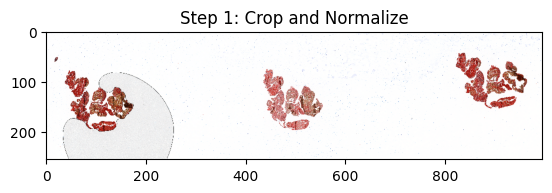

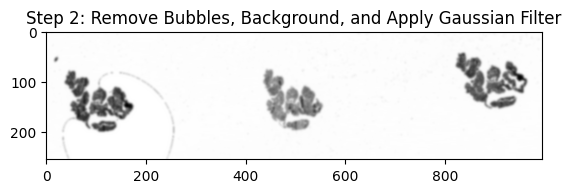

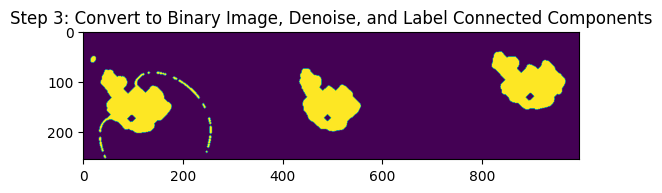

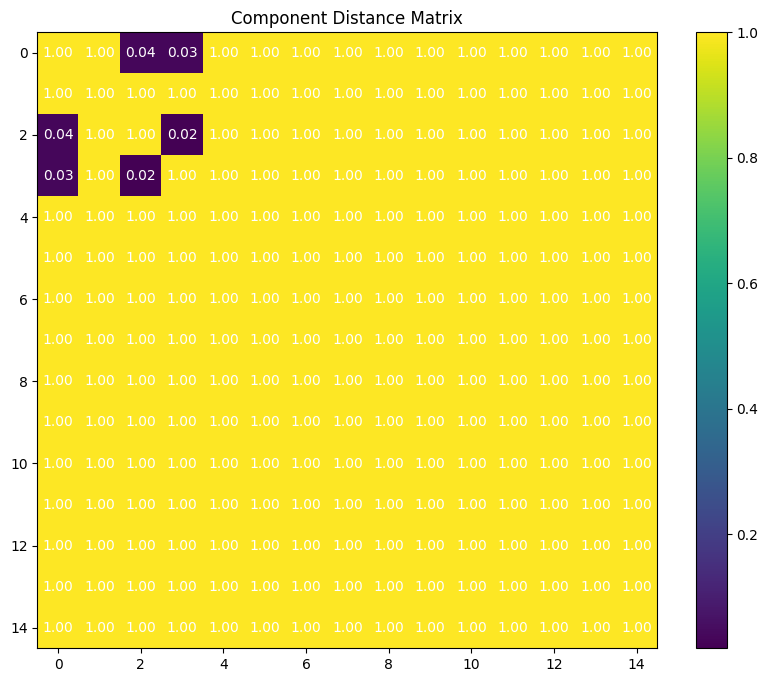

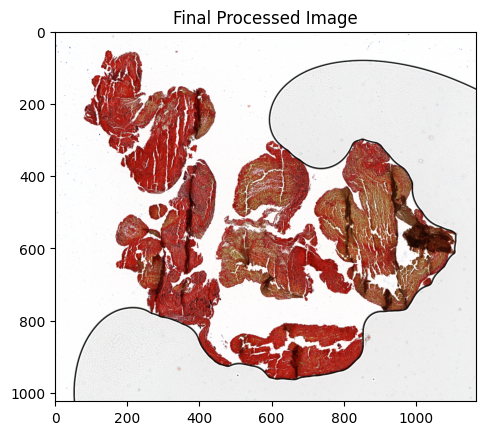

In [22]:
image_path='train/623f89_0.tif'
img=process_image(image_path)